# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

import wandb

In [218]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /Users/sharadchitlangia/.netrc


True

In [223]:
wandb_run = wandb.init(project="CovidForecaster")

# Utils

In [4]:
def compare(dataframe, fields):
    fig, ax = plt.subplots(figsize=(10,10))
    for f in fields:
        ax.plot(dataframe["Date"], dataframe[f], label=f)
    ax.legend(loc="best")

In [3]:
def mobility_check(df, where, what, everything=False, save=False):
    fig, ax = plt.subplots(figsize=(10,10))
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    ax.plot(df[df["District"]==where]["Date"], sc.fit_transform(df[df["State"]==where]["new cases"].to_numpy().reshape(-1, 1)), label=f"Cases @ {where}")
    sc = StandardScaler()
    ll = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',]
    if everything:
        for l in ll:
            ax.plot(df[df["District"]==where]["Date"], sc.fit_transform(df[df["State"]==where][l].to_numpy().reshape(-1, 1)), label=l)
    else:
        ax.plot(df[df["District"]==where]["Date"], sc.fit_transform(df[df["State"]==where][what].to_numpy().reshape(-1, 1)), label=what)
    ax.legend(loc="best")
    if save:
        plt.savefig(f"{where},{what if not everything else ''}.png")

# Data Collection and Analysis

In [2]:
df = pd.read_csv("../district_mobility_cases.csv")
df["Date"]=pd.to_datetime(df["Date"])
df.info()
df.columns = ['District', 'Date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'State', 'new cases']

# df['new cases'].dtype == float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181658 entries, 0 to 181657
Data columns (total 10 columns):
 #   Column                                              Non-Null Count   Dtype         
---  ------                                              --------------   -----         
 0   District                                            181658 non-null  object        
 1   Date                                                181658 non-null  datetime64[ns]
 2   retail_and_recreation_percent_change_from_baseline  167731 non-null  float64       
 3   grocery_and_pharmacy_percent_change_from_baseline   154821 non-null  float64       
 4   parks_percent_change_from_baseline                  169506 non-null  float64       
 5   transit_stations_percent_change_from_baseline       173456 non-null  float64       
 6   workplaces_percent_change_from_baseline             180672 non-null  float64       
 7   residential_percent_change_from_baseline            172356 non-null  float64       

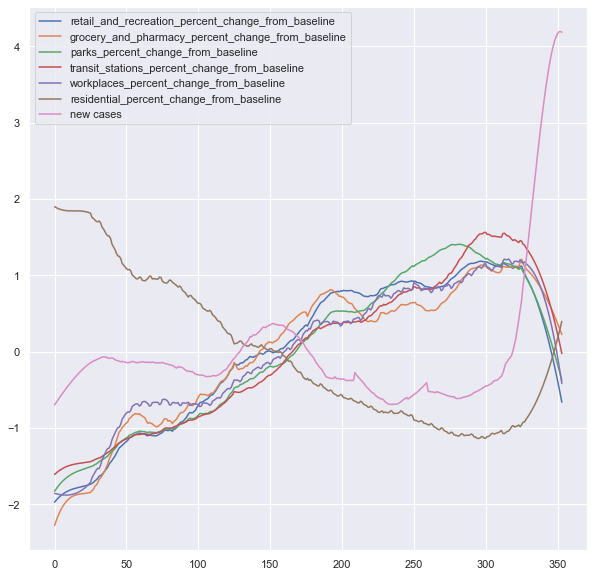

In [195]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import keras

def smooth_plot(data, ax=None, *args, **kwargs):
    data = smoothen_data(data)
    if ax is None:
        plt.plot(data, *args, **kwargs)
    else:
        ax.plot(data, *args, **kwargs)
    
def smoothen_data(data):
    return savgol_filter(data, 51, 3)

def smoothen_df(df: pd.DataFrame, cols=None):
    if cols is None:
        cols = [i for i in df.columns if df[i].dtype==float]
        
    for i in cols:
        df[i] = smoothen_data(df[i])
        
    return df
    

colstoplot = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'new cases']

mumbai = df[df['District']=='Mumbai']
scaler = StandardScaler()
scaled_mumbai = mumbai.copy()

scaled_mumbai[colstoplot] =  scaler.fit_transform(scaled_mumbai[colstoplot])

scaled_mumbai['Date'] = pd.to_datetime(scaled_mumbai['Date'])
scaled_mumbai["Date"] = scaled_mumbai["Date"].dt.year * 30 * 12 + scaled_mumbai["Date"].dt.month * 30 + scaled_mumbai["Date"].dt.day
scaled_mumbai["Date"] -= scaled_mumbai["Date"].min()

fig, ax = plt.subplots(figsize=(10,10))
for col in (colstoplot):
    smooth_plot(scaled_mumbai[col].tolist(), ax=ax, label=col)
ax.legend()
# smooth_plot()


# Algorithm Developement

In [4]:
def sliding_window(data, seq_len, j=0):

    xs = []
    ys = []
    for i in range(0,len(data)-seq_len-1-j,seq_len+1+j):
        x = data[i:(i+seq_len)].drop(["Date"], axis=1).to_numpy()
        y = data[(i+seq_len):i+seq_len+1+j]["new cases"].to_numpy().flatten()#[0]
        xs.append(x)
        ys.append(y)

  
    return np.array(xs, dtype=np.float64), np.array(ys, dtype=np.float64)

In [204]:
from tqdm import tqdm_notebook

prev_days = 28
forecast_days = 14

df = df[df['new cases']>=0]

def create_dataset(df, prev_days, forecast_days):
    xtrain, ytrain, xtest, ytest, transforms, train_idx, test_idx = [], [], [], [], [], [], []
    running_train, running_test = 0, 0
    df = df.drop(['State', *colstoplot[:-1]], axis=1)
    print(df.columns)
    for district in tqdm_notebook(df['District'].unique()):
        district_df = df[df['District']==district].copy()
        scaler = StandardScaler()
#         district_df = district_df.copy()
        if district_df.shape[0]<200:
             continue
        district_df = smoothen_df(district_df.drop('District',axis=1))

#         district_df[colstoplot] =  scaler.fit_transform(district_df[colstoplot])
#         districts_df["new cases"] = 

        district_df['Date'] = pd.to_datetime(district_df['Date'])
        district_df["Date"] = district_df["Date"].dt.year * 30 * 12 + district_df["Date"].dt.month * 30 + district_df["Date"].dt.day
        district_df["Date"] -= district_df["Date"].min()
        

        
        
#         district_df = district_df.drop('District',axis=1)

        # df_custom = smoothen_df(df_custom)
#         print(district_df)

        X, y = sliding_window(district_df[district_df['Date']<=250], prev_days, forecast_days-1)
        xt, yt = sliding_window(district_df[district_df['Date']>250], prev_days, forecast_days-1)
#         print(X.shape, y.shape, xt.shape, yt.shape)
        if 0 in X.shape or 0 in y.shape or 0 in xt.shape or 0 in yt.shape:
            continue
        transforms.append(scaler)

        train_idx.append(running_train)
        test_idx.append(running_test)
            
        running_train += X.shape[0]
        running_test += xt.shape[0]

            
        xtrain.append(X)
        ytrain.append(y)
        xtest.append(xt)
        ytest.append(yt)
        
        
    xtrain, ytrain, xtest, ytest = np.vstack(xtrain), np.vstack(ytrain), np.vstack(xtest), np.vstack(ytest)
    scaler = StandardScaler()
#     print(xtrain.shape)
#     xtrain = scaler.fit_transform(xtrain[:,:,0])
    return xtrain, ytrain, xtest, ytest, scaler
    
    #, transforms, test_idx, train_idx
    
    
def create_metadataset(df, prev_days, forecast_days, params):
    xtrain, ytrain, xtest, ytest, = [], [], [], []
    running_train, running_test = 0, 0
#     df = df.drop(['State', *colstoplot[:-1]], axis=1)
    for district in tqdm_notebook(df['District'].unique()):
        district_df = df[df['District']==district].copy()
        if district_df.shape[0]<200:
            del params[district]
            continue
        district_df = district_df.drop('District',axis=1)


        district_df['Date'] = pd.to_datetime(district_df['Date'])
        district_df["Date"] = district_df["Date"].dt.year * 30 * 12 + district_df["Date"].dt.month * 30 + district_df["Date"].dt.day
        district_df["Date"] -= district_df["Date"].min()
#         print(district_df)
        X, y = sliding_window(district_df, prev_days, forecast_days-1)
#         xt, yt = sliding_window(district_df[district_df['Date']>250], prev_days, forecast_days-1)
        if 0 in X.shape or 0 in y.shape:# or 0 in xt.shape or 0 in yt.shape:
            del params[district]
            continue
            
        xtrain.append(X)
        ytrain.append(y)
#         xtest.append(xt)
#         ytest.append(yt)
        
    return np.asarray(xtrain), np.asarray(ytrain)#, np.asarray(xtest), np.asarray(ytest)

def region_wise_normalized_df(df):
    df = df.drop(['State', *colstoplot[:-1]], axis=1)
    df = smoothen_df(df)#.drop('District',axis=1))
    params = {}
    for region in df['District'].unique():
        cases = df[df['District']==region]['new cases']
        df.loc[df['District']==region,'new cases'] = (cases - cases.min()) / (cases.max() - cases.min())
        params[region] = [cases.min(), cases.max()]
        
#     print(df)
        
    return df, params

# xtrain, ytrain, xtest, ytest, transforms, tri, tei = create_dataset(df.dropna(), 28, 14)
# xtrain, ytrain, xtest, ytest = create_metadataset(df.dropna(), 28, 14)
df_new, params = region_wise_normalized_df(df.dropna())
xtrain, ytrain = create_metadataset(df_new, 28, 14, params)

# ytrain = transform.transform(ytrain)
# xtest = transform.transform(xtest)
# ytest = transform.transform(ytest)

/Users/sharadchitlangia/miniconda3/envs/dreamcoder/lib/python3.6/site-packages/ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/457 [00:00<?, ?it/s]

/Users/sharadchitlangia/miniconda3/envs/dreamcoder/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [224]:
wandb_run.log({"r2_scores": r2_scores[0], "test_error_mae":test_error_mae[0], "test_error_mse":test_error_mse[0]})

In [225]:
wandb_run.finish()


_runtime,18
_timestamp,1619137114
_step,0


_runtime,▁
_timestamp,▁
_step,▁


In [208]:
import random
import tensorflow as tf

def get_mini_dataset(batchSize, iters, num_regions, datasets, test=False):
    # Shots is assumed to be all
    
    xtrain, ytrain = datasets
    
    regions = random.choices(list(range(xtrain.shape[0])), k=num_regions)
    
#     xtrain, ytrain = np.vstack(xtrain[[regions]]), np.vstack(ytrain[[regions]])
    
    
    if test:
        xtests, ytests, xtrains, ytrains = [], [], [], []
        xtrain, ytrain = xtrain[[regions]],ytrain[[regions]]
#         print(xtrain.shape)
#         print(ytrain.shape)
#         print(xtrain.shape, ytrain.shape)
        for i in range(num_regions):
            xtests.append(xtrain[i][-1,:,:])
            ytests.append(ytrain[i][-1,:])
            xtrains.append(xtrain[i][:-1,:,:])
            ytrains.append(ytrain[i][:-1,:])

#             xtest, ytest = xtrain[-1,:,:], ytrain[-1,:]
#             xtrain, ytrain = xtrain[:-1,:,:], ytrain[:-1,:]
        xtrain, ytrain, xtest, ytest = np.vstack(xtrains), np.vstack(ytrains), np.hstack(xtests), np.stack(ytests)

    else:
        xtrain, ytrain = np.vstack(xtrain[[regions]]), np.vstack(ytrain[[regions]])

#     xtrain, ytrain = np.vstack(xtrains), np.vstack(ytrains)
#     print(xtrain.shape, ytrain.shape)
    
    dataset = tf.data.Dataset.from_tensor_slices(
        (xtrain.astype(np.float32), ytrain.astype(np.float32))
    )
    dataset = dataset.shuffle(100).batch(batchSize).repeat(iters)
    if test:
        return dataset, tf.expand_dims(xtest.T,-1), ytest, regions
    return dataset, regions
# print(np.vstack(xtrain[[0,4,5]]).shape)

# xtrain, ytrain = create_metadataset(df.dropna(), 28, 14)
dataset, te, ti, regions = get_mini_dataset(32, 4, 20, (xtrain, ytrain), True)


/Users/sharadchitlangia/miniconda3/envs/dreamcoder/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


In [239]:
n_hidden = 10

features = 1

input_train = keras.Input(shape=(prev_days, features))
output_train = keras.Input(shape=(forecast_days, 1))

encoder_last_h1, encoder_last_h2, encoder_last_c = keras.layers.LSTM(
 n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)

decoder = keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = keras.layers.LSTM(n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2,
                            return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = keras.layers.TimeDistributed(keras.layers.Dense(1))(decoder)

model = keras.Model(inputs=input_train, outputs=out)
model.compile()
optimizer = keras.optimizers.SGD(lr=0.001, clipnorm=1)


In [240]:

# scaler = StandardScaler()
# ytrain.shape
len(params)
import warnings
warnings.filterwarnings('ignore')

In [242]:
trainingA, trainingR = [], []
testingA, testingR = [], []
meta_iters = 60
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
regions = 50

for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset, _ = get_mini_dataset(inner_batch_size, inner_iters, regions, (xtrain, ytrain))
    
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = tf.squeeze(model(images))
            loss = keras.losses.mean_squared_error(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies, r2s = [], []
        for dataset in ("train", "test"):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels, regs = get_mini_dataset(inner_batch_size, inner_iters, regions, 
                                                                   (xtrain, ytrain), True)
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = tf.squeeze(model(images))
                    loss = keras.losses.mean_squared_error(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
                
#             print(test_images.shape)
            test_preds = model.predict(test_images).squeeze()
#             mean(square(y_true - y_pred), axis=-1)
            num_correct = np.square(test_preds - test_labels).mean()
            # Reset the weights after getting the evaluation accuracies.
            r2 = r2_score(test_labels, test_preds)
            r2s.append(r2)
            model.set_weights(old_vars)
            accuracies.append(num_correct)
        trainingR.append(r2s[0])
        testingR.append(r2s[1])
        trainingA.append(accuracies[0])
        testingA.append(accuracies[1])
        if meta_iter % 10 == 0:
            print(
                "batch %d / %d: trainE=%f testE=%f trainA=%f testA=%f" % (meta_iter, meta_iters, accuracies[0], accuracies[1], r2s[0], r2s[1])
            )

batch 0 / 60: trainE=0.040552 testE=0.018604 trainA=-0.207919 testA=-0.096581
batch 10 / 60: trainE=0.084236 testE=0.065459 trainA=-0.267469 testA=-0.204737
batch 20 / 60: trainE=0.008142 testE=0.018625 trainA=-2.023014 testA=-0.443029
batch 30 / 60: trainE=0.011180 testE=0.009031 trainA=-0.983835 testA=-0.362293


KeyboardInterrupt: 

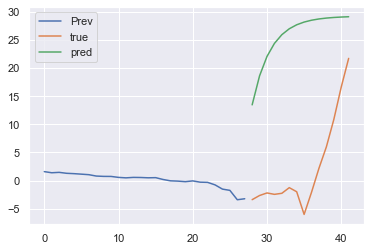

In [246]:
ind = 4
scales = list(params.items())[regs[ind]][1]
min, max = scales
plt.plot(np.arange(0,28),test_images[ind]*(max - min) + min, label='Prev')
plt.plot(np.arange(28,42),test_labels[ind]*(max - min) + min, label='true')
plt.plot(np.arange(28,42),test_preds[ind]*(max - min) + min, label='pred')
plt.legend()